<a href="https://colab.research.google.com/github/AlexandreCandidoXavier/BR-DWGD/blob/main/notebooks/exemplo3_google_earth_export_geoTiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exportando imagens BR-DWGD mensais e anuais

Objetivo: exportar em "Geotiff" os dados de precipitação da grade BR-DWGD, de uma região de interesse. Considerando as escalas de tempo mensal.

Informações sobre o asset BR-DWGD no GEE [aqui](https://code.earthengine.google.com/?asset=projects/ee-alexandrexavier/assets/BR-DWGD)

In [23]:
# ! pip install --upgrade xee
import ee
import geemap
import numpy as np
import xarray as xr
import xee
import xarray

In [24]:
ee.Authenticate()

True

In [45]:
# vc vai ter que entrar com o nome do seu projeto no Google Earth Engine
# project='seu-prjeto'
ee.Initialize(project='ee-alexandrexavier', opt_url='https://earthengine-highvolume.googleapis.com')

## Pegando variável

Informações sobre ganhos e offsets do asset BR-DWGD [aqui](https://code.earthengine.google.com/?asset=projects/ee-alexandrexavier/assets/BR-DWGD).

|Band |Scale         | offset     |Unit after rescale |
|-----|-------------:|-----------:|------------------:|
|Rs   |  0.15708661  |  -0.057087 |           MJ m-2  |
|u2   |  0.05905512  |  -0.059055 |            m s-1  |
|Tmax |  0.00106815  |       15.0 |               °C  |
|Tmin |  0.00106815  |       15.0 |               °C  |
|RH   |  0.39370079  |  -0.393701 |                %  |
|pr   |  0.00686666  |      225.0 |               mm  |
|ET   |  0.05118110  |       0.0  |               mm  |

Não deve ser colocado intervalo de tempo muito grande. Com o ROI utilizado neste exemplo, usei 2 anos, o que resultara em 48 meses, imagens.

Definições:

In [26]:
var_name = 'pr'
offset = 225
scale  = 0.00686666
time_start = '1961-01-01'
time_end = '1962-01-01'

Limites da área de interese

In [28]:
# limites xMin, yMin, xMax, yMax (lonMin, latMin, lonMax, ylatMax)
xMin, yMin, xMax, yMax = -45, -23, -38, -15

Função para reescalonar variável

In [46]:
# reescalonando
def scaleBand(image):
    scaledImage = image.multiply(scale).add(offset)

    return scaledImage.copyProperties(image, image.propertyNames())

Pegando o dado diário para o período/área

In [47]:
collection = ee.ImageCollection('projects/ee-alexandrexavier/assets/BR-DWGD') \
                         .filterDate(time_start, time_end) \
                         .map(scaleBand) \
                         .select(var_name)

In [48]:
collection.first()

Transformando a coleção em "xarray" *dataset*

In [49]:
ds = xr.open_dataset(
    collection,
    engine='ee',
    scale=.1,
    projection=collection.first().select(0).projection(),
    geometry=ee.Geometry.Rectangle(xMin, yMin, xMax, yMax),
).rename({'lon': 'x', 'lat':'y'})

In [50]:
# https://www.geopythontutorials.com/notebooks/xee_ic_to_netcdf.html
ds = ds.transpose('time', 'y', 'x') 
# ds.rio.write_crs("epsg:4326", inplace=True)

## Reamostrando para mensal

Dependendo do intervalo de tempo, pode demorar alguns minutos. Será somada as precipitações diária

In [53]:
ds_mes = ds[var_name].resample(time='ME').sum()
# se for a média mensal
# ds_mes = ds[var_name].resample(time='ME').mean()

## Aplicando máscara para continente e se precipitação menor que zero, para zero

In [56]:
# criando mascara para o continente e mar
mask_ocean = 2 * np.ones(ds[var_name].shape[1:]) * np.isnan(ds[var_name].isel(time=0))
mask_land = 1 * np.ones(ds[var_name].shape[1:]) * ~np.isnan(ds[var_name].isel(time=0))
mask_array = (mask_ocean + mask_land).values

# incorporando mascara da dataset
ds.coords['mask'] = xr.DataArray(mask_array, dims=('y', 'x'))

In [57]:
time_dim, row_dim, col_dim = ds_mes.values.shape
index_ocean = np.tile((ds.mask.values == 2) \
                      .reshape(1, row_dim, col_dim), (time_dim, 1, 1))

ds_mes.values[(index_ocean)] = np.nan
if name_var == 'pr':
    ds_mes.values[(ds_mes.values<0)] = 0

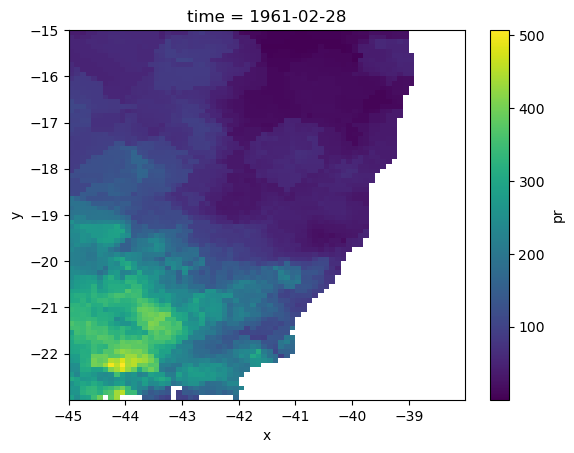

In [58]:
ds_mes.isel(time=1).plot()

## Gravando

In [59]:
ds_mes.rio.to_raster('imagem_mensal.tif')

ERROR 1: PROJ: internal_proj_create_from_database: /home/alexandre/miniconda3/envs/grade_2020/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


# Plotando dado mensal para um ponto

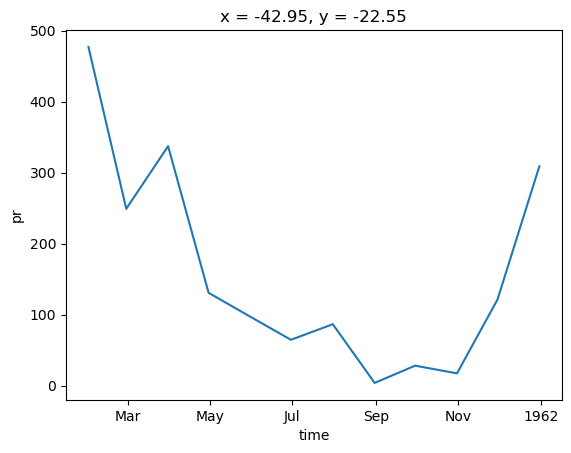

In [60]:
ds_mes.sel(x=-43, y=-22.5, method='nearest').plot()